<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Machine%20Learning%20Project/Classification/%EB%AC%B8%EC%A0%9C4_%EC%9C%A0%EB%9F%BD%EC%B6%95%EA%B5%AC%EC%8A%B9%EC%9E%90%EC%98%88%EC%B8%A1_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 유럽축구 승자 예측(분류문제유형)

### Step 0. 필요패키지 다운 및 데이터셋 준비

#### 필요패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from sklearn.feature_selection import *
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

In [ ]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'chumdan'
os.environ['KAGGLE_KEY'] = '0e8bf51ba50bce898a8a9736072bd3b8'

In [ ]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!rm *.*
!kaggle datasets download -d hugomathien/soccer
!unzip '*.zip'

 46% 15.0M/32.7M [00:00<00:00, 157MB/s]
100% 32.7M/32.7M [00:00<00:00, 209MB/s]
Archive:  soccer.zip
  inflating: database.sqlite         


#### 데이터소개 

 - 다음 1개의 csv 파일을 사용합니다.


    database.sqlite  


 - 데이터 베이스 내 총 7개의 Table을 사용합니다.


    Country: 국가 정보
    League: 리그 정보
    Match: 경기 정보 (주 데이터셋)
    Player: 플레이어 정보
    Player_Attributes: 플레이어의 특성
    Team: 팀 정보
    Team_Attributes: 팀의 특성

    종속변수: matchResult 경기결과
> 들여쓴 블록

- 데이터 출처: https://www.kaggle.com/hugomathien/soccer

In [ ]:
# sqlite3.connect()와 pd.read_sql_query()로 csv파일 읽어들이기
import sqlite3
conn = sqlite3.connect('database.sqlite')
df_country = pd.read_sql_query('SELECT * from Country', conn)
df_league = pd.read_sql_query('SELECT * from League', conn)
df_match = pd.read_sql_query('SELECT * from Match', conn)
df_player = pd.read_sql_query('SELECT * from Player', conn)
df_player_att = pd.read_sql_query('SELECT * from Player_Attributes', conn)
df_team = pd.read_sql_query('SELECT * from Team', conn)
df_team_att = pd.read_sql_query('SELECT * from Team_Attributes', conn)

### Step 1. 데이터 기초 통계 분석 및 그래프

#### 데이터프레임의 각 칼럼 분석

In [ ]:
df_country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [ ]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


In [ ]:
df_league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [ ]:
df_league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


In [ ]:
df_league['id'].unique()

array([    1,  1729,  4769,  7809, 10257, 13274, 15722, 17642, 19694,
       21518, 24558])

In [ ]:
df_league['country_id'].unique()

array([    1,  1729,  4769,  7809, 10257, 13274, 15722, 17642, 19694,
       21518, 24558])

In [ ]:
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [ ]:
for c in df_match.columns:
  print(c)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

In [ ]:
for c, num in zip(df_match.columns, df_match.isna().sum()):
  print(c, num)

id 0
country_id 0
league_id 0
season 0
stage 0
date 0
match_api_id 0
home_team_api_id 0
away_team_api_id 0
home_team_goal 0
away_team_goal 0
home_player_X1 1821
home_player_X2 1821
home_player_X3 1832
home_player_X4 1832
home_player_X5 1832
home_player_X6 1832
home_player_X7 1832
home_player_X8 1832
home_player_X9 1832
home_player_X10 1832
home_player_X11 1832
away_player_X1 1832
away_player_X2 1832
away_player_X3 1832
away_player_X4 1832
away_player_X5 1832
away_player_X6 1832
away_player_X7 1832
away_player_X8 1832
away_player_X9 1833
away_player_X10 1833
away_player_X11 1839
home_player_Y1 1821
home_player_Y2 1821
home_player_Y3 1832
home_player_Y4 1832
home_player_Y5 1832
home_player_Y6 1832
home_player_Y7 1832
home_player_Y8 1832
home_player_Y9 1832
home_player_Y10 1832
home_player_Y11 1832
away_player_Y1 1832
away_player_Y2 1832
away_player_Y3 1832
away_player_Y4 1832
away_player_Y5 1832
away_player_Y6 1832
away_player_Y7 1832
away_player_Y8 1832
away_player_Y9 1833
away_player_Y

In [ ]:
df_match.drop(df_match.columns[-38:], axis=1, inplace=True)

In [ ]:
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [ ]:
df_player_att.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [ ]:
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [ ]:
df_team_att.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [ ]:
# 데이터프레임 간 중복되는 Column이 있는지 확인하고 유용한 Column 식별

df_player_att['player_api_id'].value_counts()

210278    56
41269     56
42116     55
26472     54
179795    53
          ..
163254     2
266280     2
37366      2
238766     2
26568      2
Name: player_api_id, Length: 11060, dtype: int64

In [ ]:
df_match['home_player_1'].dropna().apply(int).map(df_player_att.groupby('player_api_id').mean()['overall_rating']).isna().sum()

0

In [ ]:
df_team_att['team_api_id'].value_counts()

8191    6
8668    6
8661    6
8659    6
8658    6
       ..
8613    1
6631    1
6351    1
8614    1
9824    1
Name: team_api_id, Length: 288, dtype: int64

In [ ]:
df_match['away_team_api_id'].map(df_team_att.groupby('team_api_id').mean()['buildUpPlaySpeed']).isna().sum()

178

#### 데이터 그래프 분석

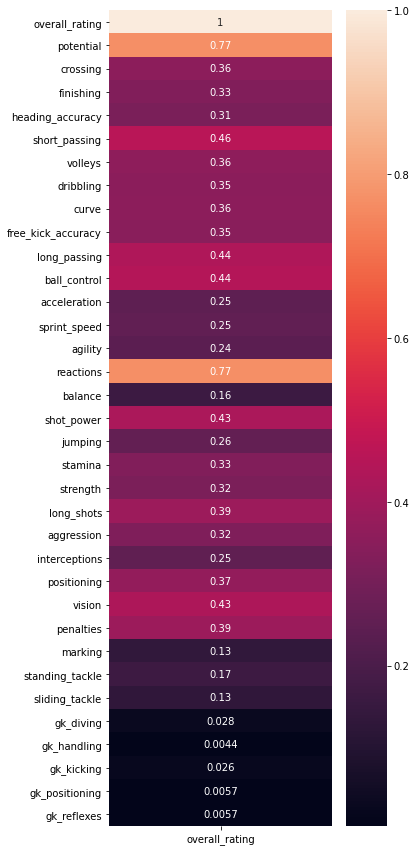

In [ ]:
# DataFrame의 corr() 메소드와 Seaborn의 heatmap() 메소드를 이용하여 Pearson's correlation 시각화하기
fig = plt.figure(figsize=(5,15))
sns.heatmap(df_player_att.drop(['id', 'player_fifa_api_id', 'player_api_id'], axis=1).corr()[['overall_rating']], annot=True)

#### 매치 데이터프레임에 팀별 특성 데이터프레임 통합하기

In [ ]:
# DataFrame의 map() 메소드를 활용하여 데이터프레임 통합\
df_team_att.columns

Index(['id', 'team_fifa_api_id', 'team_api_id', 'date', 'buildUpPlaySpeed',
       'buildUpPlaySpeedClass', 'buildUpPlayDribbling',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [ ]:
# buildUpPlayDribbling는 nan 값이 많아서, 삭제
df_team_att.drop('buildUpPlayDribbling', axis=1, inplace=True)

In [ ]:
# team_api_id 중복값이 있기때문에, team_api_id 기준으로 합침.
def most(x):
  return x.value_counts().index[0]

In [ ]:
# team_api_id 중복값이 있기때문에, team_api_id 기준으로 합침.
team_map = df_team_att.groupby('team_api_id').aggregate(
    {
       'buildUpPlaySpeed': 'mean',
       'buildUpPlaySpeedClass': most,
       'buildUpPlayDribblingClass': most,
       'buildUpPlayPassing': 'mean',
       'buildUpPlayPassingClass': most,
       'buildUpPlayPositioningClass': most,
       'chanceCreationPassing': 'mean',
       'chanceCreationPassingClass': most,
       'chanceCreationCrossing': 'mean',
       'chanceCreationCrossingClass': most,
       'chanceCreationShooting': 'mean',
       'chanceCreationShootingClass': most,
       'chanceCreationPositioningClass': most,
       'defencePressure': 'mean',
       'defencePressureClass': most,
       'defenceAggression': 'mean',
       'defenceAggressionClass': most,
       'defenceTeamWidth': 'mean',
       'defenceTeamWidthClass': most,
       'defenceDefenderLineClass': most
    }
)

In [ ]:
team_map

,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
team_api_id,,,,,,,,,,,,,,,,,,,,
1601,47.333333,Balanced,Little,46.166667,Mixed,Organised,55.500000,Normal,60.333333,Normal,53.500000,Normal,Organised,47.166667,Medium,47.333333,Press,49.333333,Normal,Cover
1773,52.000000,Balanced,Little,50.000000,Mixed,Organised,50.000000,Normal,53.000000,Normal,54.000000,Normal,Organised,43.000000,Medium,44.000000,Press,50.000000,Normal,Cover
1957,47.166667,Balanced,Little,52.666667,Mixed,Organised,50.833333,Normal,36.333333,Normal,67.000000,Lots,Organised,49.333333,Medium,56.333333,Press,53.666667,Normal,Cover
2033,49.000000,Balanced,Little,48.400000,Mixed,Organised,51.800000,Normal,44.200000,Normal,48.200000,Normal,Free Form,42.200000,Medium,33.800000,Contain,45.400000,Normal,Cover
2182,60.333333,Balanced,Little,49.000000,Mixed,Organised,56.666667,Normal,57.333333,Normal,68.000000,Lots,Organised,51.666667,Medium,48.500000,Press,54.500000,Normal,Cover
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10281,52.833333,Balanced,Little,53.666667,Mixed,Organised,50.333333,Normal,59.166667,Lots,50.333333,Normal,Organised,45.500000,Medium,51.166667,Press,52.666667,Normal,Cover
108893,43.166667,Balanced,Little,53.166667,Mixed,Organised,46.000000,Normal,38.333333,Normal,39.500000,Normal,Organised,38.333333,Medium,46.000000,Press,46.333333,Normal,Cover
158085,67.000000,Balanced,Normal,39.000000,Mixed,Organised,55.000000,Normal,59.000000,Normal,46.000000,Normal,Organised,36.000000,Medium,38.000000,Press,37.000000,Normal,Cover


In [ ]:
df = df_match[['home_team_goal', 'away_team_goal']].copy()

In [ ]:
for team in ['home_', 'away_']:
  team_map.index.name = team + 'team_api_id'
  for col in team_map.columns:
    df[team + col] = df_match[team_map.index.name].map(team_map[col])

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,away_buildUpPlaySpeed,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass
0,1,1,56.333333,Balanced,Little,44.333333,Mixed,Organised,55.666667,Normal,52.333333,Normal,55.833333,Normal,Organised,49.166667,Medium,50.666667,Press,59.833333,Normal,Cover,46.000000,Balanced,Little,41.500000,Mixed,Organised,46.000000,Normal,53.500000,Normal,53.750000,Normal,Organised,48.250000,Medium,49.000000,Press,58.750000,Normal,Cover
1,0,0,55.500000,Balanced,Little,52.666667,Mixed,Organised,50.000000,Normal,49.333333,Normal,41.500000,Little,Organised,48.666667,Medium,56.166667,Press,47.833333,Normal,Cover,64.000000,Balanced,Little,53.500000,Mixed,Organised,44.000000,Normal,47.666667,Normal,54.333333,Normal,Organised,48.833333,Medium,55.166667,Press,55.500000,Normal,Cover
2,0,3,53.666667,Balanced,Little,44.166667,Mixed,Organised,59.000000,Normal,60.333333,Normal,48.000000,Normal,Organised,60.166667,Medium,49.666667,Press,64.666667,Normal,Cover,51.333333,Balanced,Little,45.166667,Mixed,Organised,63.500000,Normal,55.000000,Normal,51.333333,Normal,Organised,59.666667,Medium,47.666667,Press,63.833333,Normal,Cover
3,5,0,54.166667,Balanced,Little,46.333333,Mixed,Organised,44.500000,Normal,64.666667,Normal,44.166667,Normal,Organised,51.333333,Medium,50.000000,Press,45.666667,Normal,Cover,51.666667,Balanced,Little,51.666667,Mixed,Organised,55.000000,Normal,60.666667,Lots,46.000000,Normal,Organised,46.000000,Medium,45.000000,Press,47.000000,Normal,Cover
5,1,1,56.666667,Balanced,Little,47.333333,Mixed,Organised,47.500000,Normal,49.833333,Normal,50.333333,Normal,Organised,47.666667,Medium,58.833333,Press,52.000000,Normal,Cover,49.166667,Balanced,Little,46.500000,Mixed,Organised,48.833333,Normal,55.833333,Normal,47.666667,Normal,Organised,53.666667,Medium,53.833333,Press,54.666667,Normal,Cover


In [ ]:
# 홈과 어웨이의 골 수를 범주형 데이터로 변환하기 (0: 홈팀 승, 1: 무승부, 2: 어웨이팀 승)
df['matchResult'] = df[['home_team_goal', 'away_team_goal']].aggregate(lambda x: 0 if x[0] > x[1] else 1 if x[0] == x[1] else 2, axis=1)

In [ ]:
df.drop(['home_team_goal', 'away_team_goal'], axis=1, inplace=True)

In [ ]:
df

,home_buildUpPlaySpeed,home_buildUpPlaySpeedClass,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_buildUpPlayPassingClass,home_buildUpPlayPositioningClass,home_chanceCreationPassing,home_chanceCreationPassingClass,home_chanceCreationCrossing,home_chanceCreationCrossingClass,home_chanceCreationShooting,home_chanceCreationShootingClass,home_chanceCreationPositioningClass,home_defencePressure,home_defencePressureClass,home_defenceAggression,home_defenceAggressionClass,home_defenceTeamWidth,home_defenceTeamWidthClass,home_defenceDefenderLineClass,away_buildUpPlaySpeed,away_buildUpPlaySpeedClass,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_buildUpPlayPassingClass,away_buildUpPlayPositioningClass,away_chanceCreationPassing,away_chanceCreationPassingClass,away_chanceCreationCrossing,away_chanceCreationCrossingClass,away_chanceCreationShooting,away_chanceCreationShootingClass,away_chanceCreationPositioningClass,away_defencePressure,away_defencePressureClass,away_defenceAggression,away_defenceAggressionClass,away_defenceTeamWidth,away_defenceTeamWidthClass,away_defenceDefenderLineClass,matchResult
0,56.333333,Balanced,Little,44.333333,Mixed,Organised,55.666667,Normal,52.333333,Normal,55.833333,Normal,Organised,49.166667,Medium,50.666667,Press,59.833333,Normal,Cover,46.000000,Balanced,Little,41.500000,Mixed,Organised,46.000000,Normal,53.500000,Normal,53.750000,Normal,Organised,48.250000,Medium,49.000000,Press,58.750000,Normal,Cover,1
1,55.500000,Balanced,Little,52.666667,Mixed,Organised,50.000000,Normal,49.333333,Normal,41.500000,Little,Organised,48.666667,Medium,56.166667,Press,47.833333,Normal,Cover,64.000000,Balanced,Little,53.500000,Mixed,Organised,44.000000,Normal,47.666667,Normal,54.333333,Normal,Organised,48.833333,Medium,55.166667,Press,55.500000,Normal,Cover,1
2,53.666667,Balanced,Little,44.166667,Mixed,Organised,59.000000,Normal,60.333333,Normal,48.000000,Normal,Organised,60.166667,Medium,49.666667,Press,64.666667,Normal,Cover,51.333333,Balanced,Little,45.166667,Mixed,Organised,63.500000,Normal,55.000000,Normal,51.333333,Normal,Organised,59.666667,Medium,47.666667,Press,63.833333,Normal,Cover,2
3,54.166667,Balanced,Little,46.333333,Mixed,Organised,44.500000,Normal,64.666667,Normal,44.166667,Normal,Organised,51.333333,Medium,50.000000,Press,45.666667,Normal,Cover,51.666667,Balanced,Little,51.666667,Mixed,Organised,55.000000,Normal,60.666667,Lots,46.000000,Normal,Organised,46.000000,Medium,45.000000,Press,47.000000,Normal,Cover,0
5,56.666667,Balanced,Little,47.333333,Mixed,Organised,47.500000,Normal,49.833333,Normal,50.333333,Normal,Organised,47.666667,Medium,58.833333,Press,52.000000,Normal,Cover,49.166667,Balanced,Little,46.500000,Mixed,Organised,48.833333,Normal,55.833333,Normal,47.666667,Normal,Organised,53.666667,Medium,53.833333,Press,54.666667,Normal,Cover,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,56.833333,Balanced,Little,50.000000,Mixed,Organised,48.000000,Normal,55.166667,Normal,53.500000,Normal,Organised,48.666667,Medium,46.000000,Press,55.666667,Normal,Cover,56.600000,Balanced,Little,35.800000,Mixed,Organised,63.200000,Normal,36.400000,Normal,59.000000,Normal,Organised,45.000000,Medium,42.800000,Press,51.600000,Normal,Cover,1
25974,47.600000,Balanced,Little,51.800000,Mixed,Organised,39.800000,Normal,45.200000,Normal,44.400000,Normal,Organised,43.800000,Medium,45.600000,Press,50.800000,Normal,Cover,56.600000,Balanced,Little,35.800000,Mixed,Organised,63.200000,Normal,36.400000,Normal,59.000000,Normal,Organised,45.000000,Medium,42.800000,Press,51.600000,Normal,Cover,0
25975,53.000000,Balanced,Little,56.000000,Mixed,Organised,38.000000,Normal,53.000000,Normal,46.000000,Normal,Organised,42.000000,Medium,33.000000,Contain,58.000000,Normal,Cover,51.833333,Balanced,Little,52.500000,Mixed,Organised,53.000000,Normal,48.333333,Normal,61.000000,Normal,Organised,48.000000

### Step 2. 모델 학습을 위한 전처리

#### get_dummies를 이용하여 범주형 데이터 전처리하기

In [ ]:
# Class가 붙어 있는 변수는 범주형 변수임.
col_cats = list(filter(lambda s: s.find('Class') >= 0, df.columns))
df_cats = pd.get_dummies(df[col_cats], drop_first=True)
df_cats

,home_buildUpPlaySpeedClass_Fast,home_buildUpPlaySpeedClass_Slow,home_buildUpPlayDribblingClass_Normal,home_buildUpPlayPassingClass_Mixed,home_buildUpPlayPassingClass_Short,home_buildUpPlayPositioningClass_Organised,home_chanceCreationPassingClass_Risky,home_chanceCreationPassingClass_Safe,home_chanceCreationCrossingClass_Lots,home_chanceCreationCrossingClass_Normal,home_chanceCreationShootingClass_Lots,home_chanceCreationShootingClass_Normal,home_chanceCreationPositioningClass_Organised,home_defencePressureClass_High,home_defencePressureClass_Medium,home_defenceAggressionClass_Double,home_defenceAggressionClass_Press,home_defenceTeamWidthClass_Normal,home_defenceTeamWidthClass_Wide,home_defenceDefenderLineClass_Offside Trap,away_buildUpPlaySpeedClass_Fast,away_buildUpPlaySpeedClass_Slow,away_buildUpPlayDribblingClass_Normal,away_buildUpPlayPassingClass_Mixed,away_buildUpPlayPassingClass_Short,away_buildUpPlayPositioningClass_Organised,away_chanceCreationPassingClass_Risky,away_chanceCreationPassingClass_Safe,away_chanceCreationCrossingClass_Lots,away_chanceCreationCrossingClass_Normal,away_chanceCreationShootingClass_Lots,away_chanceCreationShootingClass_Normal,away_chanceCreationPositioningClass_Organised,away_defencePressureClass_High,away_defencePressureClass_Medium,away_defenceAggressionClass_Double,away_defenceAggressionClass_Press,away_defenceTeamWidthClass_Normal,away_defenceTeamWidthClass_Wide,away_defenceDefenderLineClass_Offside Trap
0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
2,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
3,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,0
5,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
25974,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
25975,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0
25976,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,1,1,0,0


#### scaler = StandardScaler()를 이용해 수치형 데이터 표준화하기

In [ ]:
X_num = df.drop(['matchResult'] + col_cats, axis=1)
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(data=X_scaled, index=X_num.index, columns=X_num.columns)

X_cat = df_cats
X = pd.concat([X_scaled, X_cat], axis=1)
y = df['matchResult']

#### 학습데이터와 테스트데이터 분리

In [ ]:
# train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Step 3. Classification 모델 학습하기(y : 다중분류문제유형)

-  기본 모델은 로지스틱 모델로 설정.
-  데이터가 크기 때문에 LGBM만 하이퍼파라미터 조절을 통해 분석해본다.

In [ ]:
# 결정계수를 설정해서 가장 적합한 로지스틱분석의 결정계수를 정한다.
def LR_model_test(C):
    model = LR(C = C, max_iter = 100000, random_state = 10).fit(X_train, y_train) # 가벼운 모델이므로 max_iter를 크게 잡음
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='micro')
print("C = 0.1:\t{}".format(LR_model_test(C = 0.1)))

print("C = 0.3:\t{}".format(LR_model_test(C = 0.3)))
print("C = 0.5:\t{}".format(LR_model_test(C = 0.5)))
print("C = 1:\t{}".format(LR_model_test(C = 1)))
print("C = 2:\t{}".format(LR_model_test(C = 2)))
# cut-off 범위로 큰 차이를 얻을 수 없음. 그냥 0.5로 한다.

C = 0.1:	0.4792560801144492
C = 0.3:	0.4791260241904019
C = 0.5:	0.4795161919625439
C = 1:	0.4792560801144492
C = 2:	0.4792560801144492


In [ ]:
model_lr = LR(C = 0.5, max_iter = 100000, random_state = 10)
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Predict를 수행하고 classification_report() 결과 출력하기
pred_lr = model_lr.predict(X_test)
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.49      0.87      0.63      3484
           1       0.33      0.00      0.01      1972
           2       0.44      0.28      0.34      2233

    accuracy                           0.48      7689
   macro avg       0.42      0.39      0.33      7689
weighted avg       0.43      0.48      0.39      7689



#### 파라미터 그리드 설계

In [ ]:
# 모델 파라미터 그리드 설계
# 키가 모델의 함수, 값이 파라미터 그리드의 값
param_grid = dict() 


# param_grid_for_SVM = ParameterGrid({"C": [0.1, 1, 10],
                                    # "kernel":['rbf', 'linear']})

param_grid_for_LGBM = ParameterGrid({"max_depth": [2, 3, 4],
                                     "n_estimators": [50, 100],
                                      "learning_rate": [0.1, 0.15, 0.2]})

# param_grid[SVC] = param_grid_for_SVM
param_grid[LGBM] = param_grid_for_LGBM



# 튜닝 시작
best_score = 0
iteration_num = 0    
for k in range(30, 5, -1): 
    print(k)
  
    for model_func in [LGBM]:
        for param in param_grid[model_func]:
            model = model_func(**param).fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = f1_score(y_test, y_pred, average = 'micro')
            if score > best_score:
                best_model_func = model_func
                best_score = score
                best_parameter = param
            iteration_num += 1      


print("모델:", best_model_func)
print("점수:", best_score)
print("파라미터:", best_parameter)   


30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
모델: <class 'lightgbm.sklearn.LGBMClassifier'>
점수: 0.5089088307972428
파라미터: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
from sklearn.metrics import classification_report
final_model=LGBM(max_depth=4, n_estimators=100,learning_rate=0.15)

final_model.fit(X_train, y_train)
pred = final_model.predict(X_test)
print(classification_report(y_test, pred))
# 기본 모델인 로지스틱 모델에 비해서 f1-score가 0.01 상승했다.0.03 상승했다

              precision    recall  f1-score   support

           0       0.52      0.86      0.65      3484
           1       0.30      0.04      0.07      1972
           2       0.50      0.38      0.43      2233

    accuracy                           0.51      7689
   macro avg       0.44      0.43      0.38      7689
weighted avg       0.46      0.51      0.44      7689



#### 특징중요도 파악

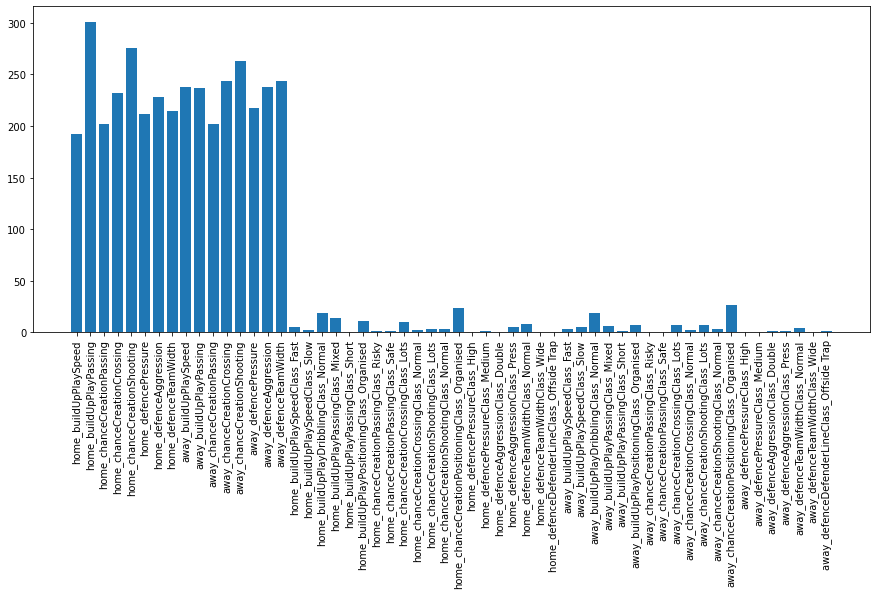

In [ ]:
fig = plt.figure(figsize=(15, 6))
plt.bar(X.columns, final_model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### Step 4. 딥러닝.신경망 모델로 분석

In [ ]:
from keras.optimizers import Adam

In [ ]:
print(X_train.shape, y_train.shape)

(17940, 56) (17940,)


#### PCA를 이용해 데이터 전처리

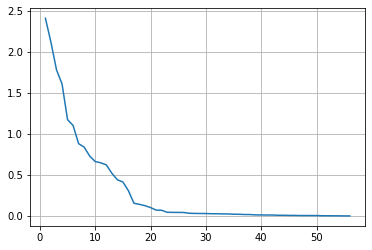

In [ ]:
pca = PCA()
pca.fit(X_train)
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_)
plt.grid()

In [ ]:
pca = PCA(n_components=17)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
X_train.shape

(17940, 17)

#### 모델작업

In [ ]:
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',input_shape=(17,)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())
    # model.add(layers.Dropout(0.5))

  
    model.add(layers.Dense(1, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                576       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                2112      
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_15 (Dense)             (None, 16)               

#### 딥러닝 모델 학습

In [ ]:
# 콜백 함수 적용 부분(분류모델은 val_loss로)
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# 분류모델이면 model_checkpoint = ModelCheckpoint(filepath='./{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/practice/문제4_딥러닝파라미터/{epoch}-{loss:.2f}.h5', 
                                   monitor='val_loss', save_best_only=True, verbose=1)


history = model.fit(X_train, y_train, batch_size=16,  epochs=1000,
            callbacks=[early_stopping_callback, model_checkpoint],
            validation_data=(X_test, y_test))

Epoch 1/1000
1122/1122 [==============================] - 6s 5ms/step - loss: 0.0000e+00 - acc: 0.2570 - val_loss: 0.0000e+00 - val_acc: 0.2565

Epoch 00001: val_loss improved from inf to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/practice/문제4_딥러닝파라미터/1-0.00.h5
Epoch 2/1000
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - acc: 0.2477 - val_loss: 0.0000e+00 - val_acc: 0.2565

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/1000
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - acc: 0.2529 - val_loss: 0.0000e+00 - val_acc: 0.2565

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/1000
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - acc: 0.2542 - val_loss: 0.0000e+00 - val_acc: 0.2565

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/1000
1122/1122 [==============================] - 5s 5ms/step - loss: 0.0000e+00 - acc: 0.2517 - val_loss: 0.

#### 딥러닝 모델평가

In [ ]:
model.evaluate(X_test, y_test)

241/241 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - acc: 0.2565


[0.0, 0.25647029280662537]

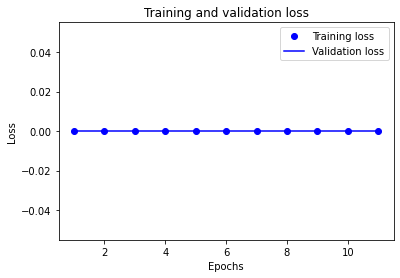

In [ ]:
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

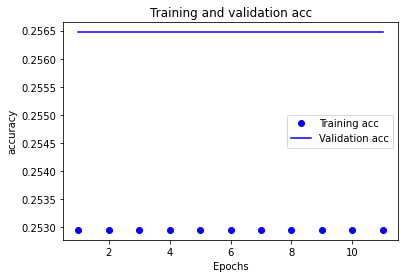

In [ ]:
plt.clf()   # 그래프를 초기화합니다
acc = history.history['acc'] 
val_acc = history.history['val_acc'] 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()